In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import imblearn

import xgboost as xgb

from sklearn.metrics import classification_report, accuracy_score
import scikitplot as skplt

from IPython.display import display
import pickle

pd.set_option('display.max_columns', None)

In [2]:
def import_data():
    X_train = pd.read_csv('./train/X_train.csv')
    X_test = pd.read_csv('./test/X_test.csv')
    y_train = pd.read_csv('./train/y_train.csv')
    y_test = pd.read_csv('./test/y_test.csv')
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = import_data()

In [4]:
y_train.value_counts()

0            
No-Recidivism    2997
Non-Violent       649
Violent           148
dtype: int64

In [5]:
X_train.shape

(3794, 29)

In [6]:
X_train.head(5).T

,0,1,2,3,4
id,2677,548,4483,9476,199
name,nicholas staggewise,newton smith,terrance irvin,jaimie peterson,ritesh sukhlall
first,nicholas,newton,terrance,jaimie,ritesh
last,staggewise,smith,irvin,peterson,sukhlall
sex,Male,Male,Male,Female,Male
date_of_birth,1994-02-28,1995-01-28,1984-04-10,1986-01-02,1987-05-12
age,22,21,32,30,28
age_group,Less than 25,Less than 25,25 - 45,25 - 45,25 - 45
race,Caucasian,African-American,African-American,African-American,Caucasian
juv_fel_count,0,0,0,0,0


### Features to engineer

In [7]:
# Month out of jail
# smaller age bins
# nlp on charges

#### Month out of jail

In [8]:
#X_train['out_month'] = X_train['out_custody'].fillna('0-13-0').str.split('-').apply(lambda x:x[1])

#### Age Bins

In [9]:
X_train['age_group'], bins = pd.qcut(X_train['age'],10,retbins=True)
X_test['age_group'] = pd.cut(X_test["age"], bins=bins, include_lowest=True)

In [10]:
X_train['age_group']=X_train['age_group'].astype(str).str.replace('(','').str.replace(']','').str.replace(', ','-')
X_test['age_group']=X_test['age_group'].astype(str).str.replace('(','').str.replace(']','').str.replace(', ','-')

In [11]:
X_train['age_group'].value_counts()

17.999-23.0    518
27.0-30.0      440
33.0-37.0      398
47.4-54.0      381
54.0-83.0      378
41.0-47.4      369
23.0-25.0      346
30.0-33.0      343
25.0-27.0      317
37.0-41.0      304
Name: age_group, dtype: int64

In [12]:
X_test['age_group'].value_counts()

17.999-23.0    130
33.0-37.0      110
54.0-83.0       96
27.0-30.0       95
30.0-33.0       93
47.4-54.0       93
23.0-25.0       89
41.0-47.4       84
37.0-41.0       80
25.0-27.0       79
Name: age_group, dtype: int64

#### time in jail

In [13]:
def date_difference(start,end):
    start = pd.to_datetime(start).dt.date
    end  = pd.to_datetime(end).dt.date
    return (end-start).dt.days.fillna(-1).astype(int)+1

In [14]:
X_train['c_time']=date_difference(X_train['c_jail_in'],X_train['c_jail_out'])
X_train['r_time']=date_difference(X_train['r_jail_in'],X_train['r_jail_out'])

In [15]:
X_test['c_time']=date_difference(X_test['c_jail_in'],X_test['c_jail_out'])
X_test['r_time']=date_difference(X_test['r_jail_in'],X_test['r_jail_out'])

#### Charges

In [16]:
charge_map = pickle.load(open('charge_map.pkl', 'rb'))

### Preprocessing

In [17]:
drop = ['id', 'name', 'first', 'last',  'date_of_birth', 'age',
        'c_jail_in', 'c_jail_out', 'c_offense_date', 'c_arrest_date',
       'r_jail_in', 'r_jail_out',
       'type_of_assessment', 'screening_date', 'v_type_of_assessment',
       'v_screening_date', 'in_custody', 'out_custody', 'start','days_b_screening_arrest','start']

multi_cat =  ['age_group','c_charge_desc','race']
binary_cat = ['sex','c_charge_degree',]
continuous = ['juv_fel_count', 'juv_misd_count','juv_other_count', 'priors_count','c_time','r_time','priors_count']              

In [18]:
X_train.drop(drop,inplace=True,axis=1)
X_test.drop(drop,inplace=True,axis=1)

#### Missing Values

In [19]:
X_train.isnull().sum()

sex                 0
age_group           0
race                0
juv_fel_count       0
juv_misd_count      0
juv_other_count     0
priors_count        0
c_charge_degree     0
c_charge_desc      12
c_time              0
r_time              0
dtype: int64

In [20]:
X_test.isnull().sum()

sex                0
age_group          0
race               0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
priors_count       0
c_charge_degree    0
c_charge_desc      5
c_time             0
r_time             0
dtype: int64

In [21]:
#mean = X_train['days_b_screening_arrest'].mean()

#X_train['days_b_screening_arrest'].fillna(mean,inplace=True)
#X_test['days_b_screening_arrest'].fillna(mean,inplace=True)

In [22]:
X_train['c_charge_desc'].fillna('arrest case no charge',inplace=True)
X_test['c_charge_desc'].fillna('arrest case no charge',inplace=True)

In [23]:
X_train['c_charge_desc'] = X_train['c_charge_desc'].map(charge_map)
X_test['c_charge_desc'] = X_test['c_charge_desc'].map(charge_map)

In [24]:
X_train['c_charge_desc'].value_counts()

 14    879
-1     632
 15    330
 12    301
 4     289
 13    259
 5     180
 8     160
 1     158
 10    143
 2     117
 9      75
 0      75
 11     73
 7      54
 3      35
 6      34
Name: c_charge_desc, dtype: int64

#### Encoding

In [25]:
oh_enc = OneHotEncoder(drop='first',handle_unknown='error',sparse=False)
label_enc=LabelEncoder()
scaler = StandardScaler()

In [26]:
col_trans = ColumnTransformer([('categorical', oh_enc, multi_cat+binary_cat)], 
                              remainder='passthrough',sparse_threshold=1)

In [27]:
X_train = pd.DataFrame(col_trans.fit_transform(X_train),columns = col_trans.get_feature_names())
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
y_train = label_enc.fit_transform(y_train.iloc[:,0])

In [28]:
X_test = pd.DataFrame(col_trans.transform(X_test),columns = col_trans.get_feature_names())
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
y_test = label_enc.transform(y_test.iloc[:,0])

#### Basic Model

In [29]:
def modelling(model,X_train=X_train,y_train=y_train):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print(model.score(X_test,y_test))
    print(classification_report(y_test,y_pred))
    df = (pd.DataFrame(zip(X_train.columns,model.feature_importances_)
             ,columns =['feature','importance']).sort_values(by='importance',ascending=False).head(10))
    display(df)
    
    fig,ax=plt.subplots(ncols=2,figsize = (16,6))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, ax = ax[1])
    skplt.metrics.plot_roc(y_test,y_prob,ax=ax[0])
    plt.show()
    return model

0.9062170706006323
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       751
           1       0.86      0.68      0.76       170
           2       0.00      0.00      0.00        28

    accuracy                           0.91       949
   macro avg       0.59      0.56      0.57       949
weighted avg       0.88      0.91      0.89       949



,feature,importance
36,c_time,0.152385
35,priors_count,0.131350
37,r_time,0.130049
26,categorical__x2_Caucasian,0.033621
30,categorical__x3_Male,0.032483
23,categorical__x1_14,0.032408
6,categorical__x0_41.0-47.4,0.030124
0,categorical__x0_23.0-25.0,0.028378
31,categorical__x4_M,0.028021
7,categorical__x0_47.4-54.0,0.026615


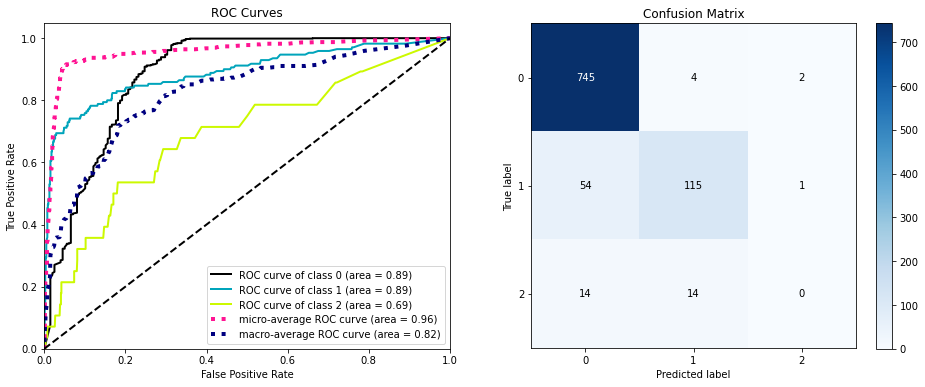

In [30]:
model = RandomForestClassifier(n_estimators=1000,n_jobs=8,class_weight={0:1,1:2,2:200})
fit_model = modelling(model)

### XGBoost

In [36]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

In [37]:
#dtrain.set_weight([10 if i == 2 else (2 if i == 1 else 1) for i in y_train])

In [38]:
param = {
    'max_depth':10,
    'eta':.1,
    'objective':'multi:softprob',
    'num_class':3}
num_round = 200

In [39]:
def xgb_model(dtrain=dtrain, dtest=dtest, param=param, num_round=num_round, y_test=y_test):
    
    bst = xgb.train(param, dtrain, num_round,
                    evals=[(dtrain, 'train'), (dtest, 'valid')], 
                    early_stopping_rounds=10)
    
    y_prob = bst.predict(dtest)
    y_pred = np.argmax(y_prob,axis=1)
    
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    
    #Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
    df = pd.DataFrame.from_dict(bst.get_score(importance_type= 'gain'),orient='index').head(10)
    display(df)
    
    fig,ax=plt.subplots(ncols=2,figsize = (16,6))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, ax = ax[1])
    skplt.metrics.plot_roc(y_test,y_prob,ax=ax[0])
    plt.show()
    return bst

[17:40:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:0.98142	valid-mlogloss:0.98586
[1]	train-mlogloss:0.88397	valid-mlogloss:0.89281
[2]	train-mlogloss:0.80073	valid-mlogloss:0.81464
[3]	train-mlogloss:0.72967	valid-mlogloss:0.74865
[4]	train-mlogloss:0.66810	valid-mlogloss:0.69111
[5]	train-mlogloss:0.61473	valid-mlogloss:0.64200
[6]	train-mlogloss:0.56819	valid-mlogloss:0.59966
[7]	train-mlogloss:0.52683	valid-mlogloss:0.56305
[8]	train-mlogloss:0.49007	valid-mlogloss:0.53113
[9]	train-mlogloss:0.45764	valid-mlogloss:0.50350
[10]	train-mlogloss:0.42878	valid-mlogloss:0.47941
[11]	train-mlogloss:0.40321	valid-mlogloss:0.45872
[12]	train-mlogloss:0.37986	valid-mlogloss:0.43979
[13]	train-mlogloss:0.35904	valid-ml

,0
r_time,18.792363
priors_count,0.633129
juv_misd_count,0.603606
juv_other_count,0.500195
c_time,0.549243
categorical__x1_5,0.504111
categorical__x0_27.0-30.0,0.532005
categorical__x0_30.0-33.0,0.553778
categorical__x0_25.0-27.0,0.377699
categorical__x0_23.0-25.0,0.489277


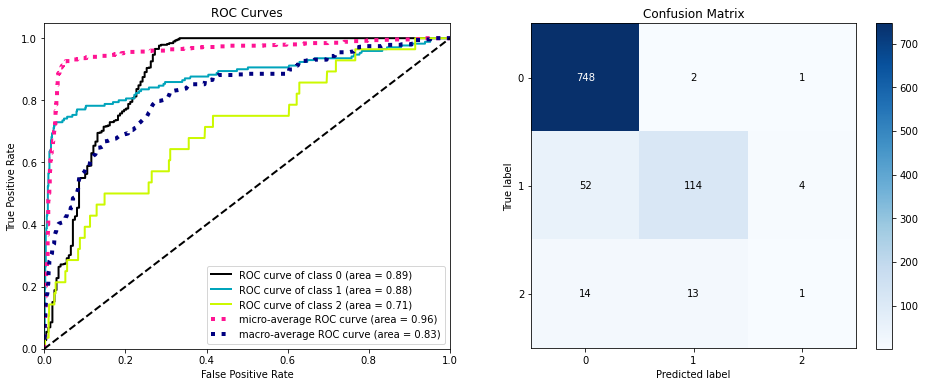

In [40]:
fit_model = xgb_model()

In [41]:
results = pd.DataFrame(fit_model.predict(dtest),columns=['No-Recidivism','Non-Violent','Violent'])
results.to_csv('results.csv',index=False)

#### Oversampling

In [42]:
pd.DataFrame(y_train).value_counts()

0    2997
1     649
2     148
dtype: int64

In [43]:
oversample = imblearn.over_sampling.SMOTE(sampling_strategy={0:2997,1:2997,2:2997})
X, y = oversample.fit_resample(X_train, y_train)
pd.DataFrame(y).value_counts()

2    2997
1    2997
0    2997
dtype: int64

In [44]:
rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={0:2500})
X, y = rus.fit_resample(X, y)
pd.DataFrame(y).value_counts()

2    2997
1    2997
0    2500
dtype: int64

0.8935721812434141
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       751
           1       0.83      0.66      0.73       170
           2       0.14      0.07      0.10        28

    accuracy                           0.89       949
   macro avg       0.63      0.57      0.59       949
weighted avg       0.88      0.89      0.88       949



,feature,importance
37,r_time,0.301504
35,priors_count,0.119785
36,c_time,0.111829
26,categorical__x2_Caucasian,0.045281
31,categorical__x4_M,0.035294
30,categorical__x3_Male,0.029650
33,juv_misd_count,0.025710
23,categorical__x1_14,0.024348
2,categorical__x0_27.0-30.0,0.022081
34,juv_other_count,0.022070


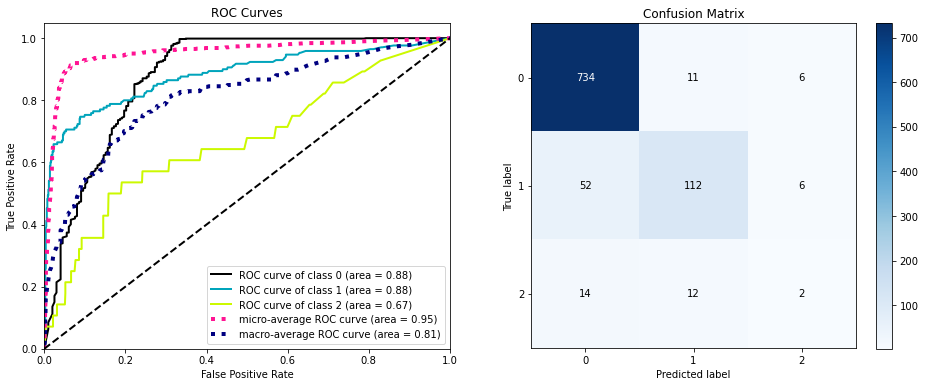

RandomForestClassifier(n_estimators=1000, n_jobs=8)

In [45]:
model = RandomForestClassifier(n_estimators=1000,n_jobs=8)
modelling(model,X,y)

In [46]:
dtrain = xgb.DMatrix(data=X,label=y)
dtest = xgb.DMatrix(data=X_test,label=y_test)

[17:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.00227	valid-mlogloss:0.99934
[1]	train-mlogloss:0.92105	valid-mlogloss:0.91550
[2]	train-mlogloss:0.84999	valid-mlogloss:0.84428
[3]	train-mlogloss:0.78676	valid-mlogloss:0.78308
[4]	train-mlogloss:0.73151	valid-mlogloss:0.73133
[5]	train-mlogloss:0.68219	valid-mlogloss:0.68517
[6]	train-mlogloss:0.63924	valid-mlogloss:0.64580
[7]	train-mlogloss:0.60045	valid-mlogloss:0.61083
[8]	train-mlogloss:0.56446	valid-mlogloss:0.58073
[9]	train-mlogloss:0.53167	valid-mlogloss:0.55435
[10]	train-mlogloss:0.50175	valid-mlogloss:0.53124
[11]	train-mlogloss:0.47531	valid-mlogloss:0.51160
[12]	train-mlogloss:0.45093	valid-mlogloss:0.49413
[13]	train-mlogloss:0.42889	valid-ml

,0
r_time,22.918272
priors_count,3.600989
c_time,2.143042
categorical__x3_Male,2.397090
categorical__x4_M,3.130311
categorical__x0_25.0-27.0,2.702201
categorical__x2_Hispanic,2.555754
categorical__x0_30.0-33.0,2.231040
categorical__x0_33.0-37.0,2.070928
juv_other_count,2.210110


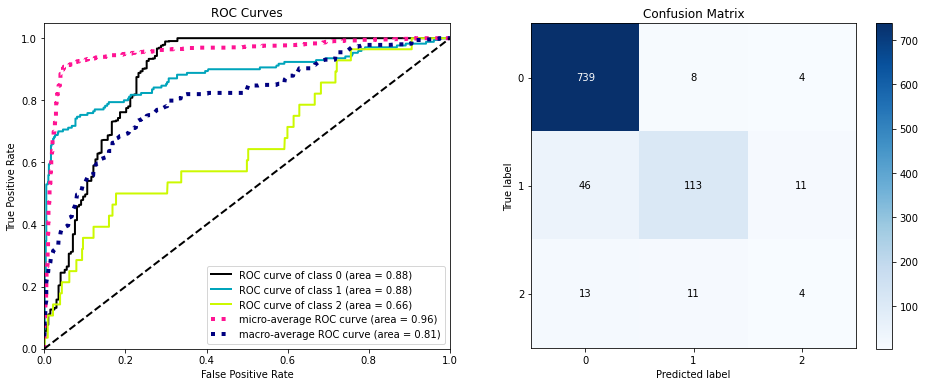

In [47]:
fit_model_2 = xgb_model(dtrain=dtrain,dtest=dtest)